In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




In [3]:
combined_stats = pd.read_csv('Data/FantasyFootball_2025.csv')

In [5]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthGrades,2023HealthGrades2,2023Cmp,2023Att,...,2025Int,2025RushAtt,2025RushYds,2025RushTD,2025Rec,2025RecYds,2025RecTD,2025FL,2025TD,2025PPR
0,6,Lamar Jackson,BAL,QB,26,16,0,Healthy,307,457,...,6,148.0,952,4,0,0,0,5,40,450.0
1,21,Ja'Marr Chase,CIN,WR,23,16,0,Healthy,1,1,...,0,3.0,21,0,119,1607,14,0,14,367.1
2,1,Josh Allen,BUF,QB,27,17,0,Healthy,385,579,...,6,113.0,561,10,0,0,0,2,41,431.3
3,11,Joe Burrow,CIN,QB,27,10,3,Moderate Injuries,244,365,...,9,44.0,190,3,0,0,0,4,42,439.1
4,26,Baker Mayfield,TAM,QB,28,17,0,Healthy,364,566,...,18,61.0,326,3,0,0,0,3,38,389.7


In [7]:
combined_stats.groupby('FantPos')['2025PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,283.415789,120.582468,15.7,270.55,315.3,356.35,450.0
RB,89.0,141.832584,80.899598,35.3,82.30,125.8,190.40,316.9
TE,45.0,137.075556,51.315079,54.4,104.60,128.8,166.50,262.6
WR,109.0,176.338532,63.752098,0.0,131.00,159.4,219.10,367.1


In [9]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           281 non-null    int64  
 1   Player                       281 non-null    object 
 2   Tm                           237 non-null    object 
 3   FantPos                      281 non-null    object 
 4   2023Age                      281 non-null    int64  
 5   2023G                        281 non-null    int64  
 6   2023HealthGrades             281 non-null    int64  
 7   2023HealthGrades2            281 non-null    object 
 8   2023Cmp                      281 non-null    int64  
 9   2023Att                      281 non-null    int64  
 10  2023PassYds                  281 non-null    int64  
 11  2023PassTD                   281 non-null    int64  
 12  2023Int                      281 non-null    int64  
 13  2023RushAtt         

In [11]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [13]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

## Evaluate data using Train, Test, and Split with Random Forest Regressor.

In [16]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

        
      # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model
    rf = RandomForestRegressor(
        n_estimators=200, 
        max_depth=20, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    train_df = position_data.loc[idx_train, ['Player', 'FantPos', '2025PPR']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'Predicted Fantasy Points'] = y_pred_train

    test_df = position_data.loc[idx_test, ['Player', 'FantPos', '2025PPR']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'Predicted Fantasy Points'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']



# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_RFR.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 11.921623759222026
RB - Testing MAE: 36.41764080687835

RB - Feature Importances:
             Feature  Importance
17  2025HealthGrades    0.329362
7        2024RushAtt    0.306991
9         2024RushTD    0.087791
11        2024RecYds    0.086065
10           2024Rec    0.041161
16  2024HealthGrades    0.020290
15           2025Age    0.017689
1        2023RushYds    0.015116
8        2024RushYds    0.014588
3            2023Rec    0.013814
0        2023RushAtt    0.013714
4          2023RecTD    0.011484
12         2024RecTD    0.011140
14       HealthGrade    0.008845
2         2023RushTD    0.006450
6             2023TD    0.006207
13            2024FL    0.005717
5             2023FL    0.003575

WR - Training MAE: 11.758324018302838
WR - Testing MAE: 22.142165103961645

WR - Feature Importances:
             Feature  Importance
10           2024Rec    0.601662
3            2023Rec    0.060517
12         2024RecTD    0.051724
15           2025Age    0.046913
11 

In [18]:

# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.890  16.88
1       WR  0.909  13.24
2       TE  0.884  12.77
3       QB  0.939  22.38


In [20]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list
position_metrics = []

# Filter for test data only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

for pos in test_only['FantPos'].unique():
    subset = test_only[test_only['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position: (Testing)")
print(position_metrics_df)


Performance Metrics by Position: (Testing)
  Position     R²    MAE
0       RB  0.616  36.42
1       WR  0.785  22.14
2       TE  0.639  24.64
3       QB  0.880  46.28


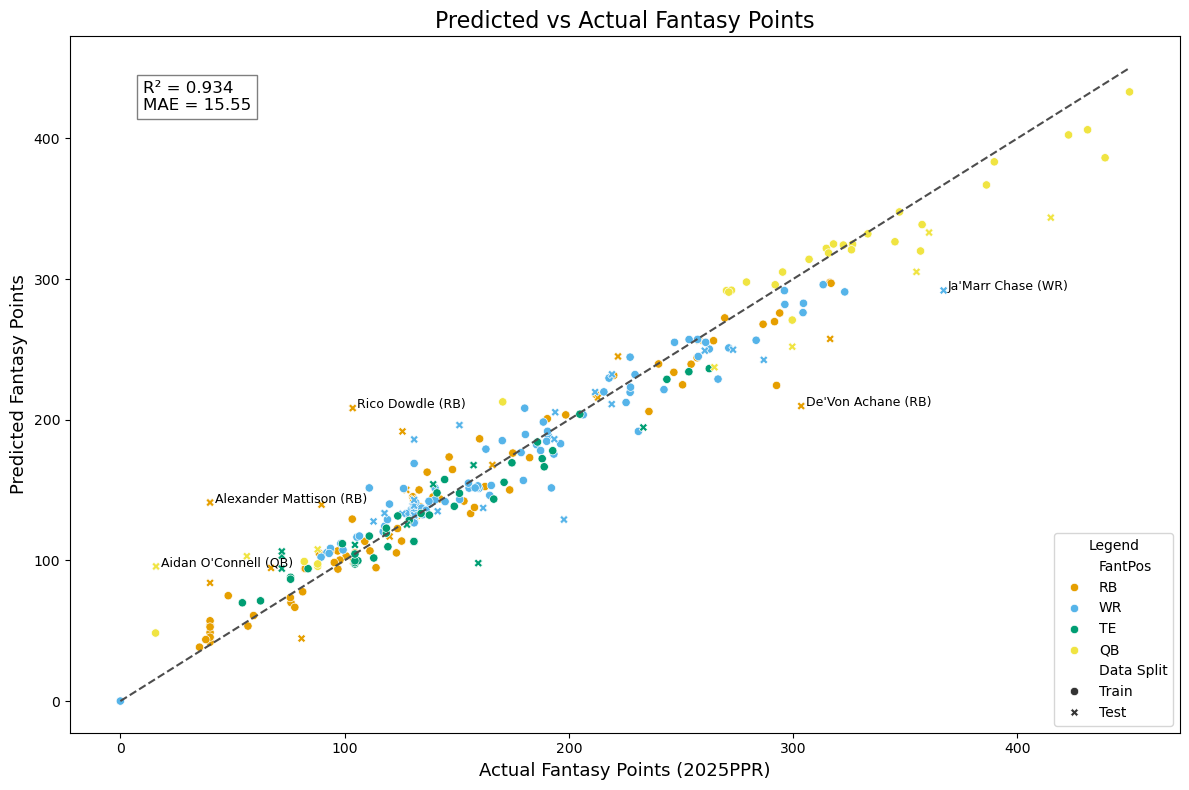

In [24]:

# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design and Colorblind safe)

color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=all_predictions,
    x='2025PPR', y='Predicted Fantasy Points',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['2025PPR'].min()
max_val = all_predictions['2025PPR'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual Fantasy Points', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

## Now we will use Cross Validation to determine the fantasy football projected scores without the 2025 projected data.

In [27]:
# Function to train and predict for a specific position using cross-validation

def train_and_predict_cv(position, features, cv=5):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Get out-of-fold predictions (no leakage)
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Calculate CV MAE
    mae = mean_absolute_error(y, y_pred)
    print(f"\n{position} - Cross-Validated MAE: {mae:.2f}")

    # Fit the model on the full dataset to get final feature importances
    rf.fit(X, y)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['Predicted Fantasy Points'] = y_pred

    return position_data[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict_cv('RB', rb_features)
wr_predictions = train_and_predict_cv('WR', wr_features)
te_predictions = train_and_predict_cv('TE', te_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_CV.csv"
all_predictions[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE: 32.12

RB - Feature Importances:
             Feature  Importance
7        2024RushAtt    0.261262
17  2025HealthGrades    0.231831
9         2024RushTD    0.204883
11        2024RecYds    0.094318
1        2023RushYds    0.037061
10           2024Rec    0.026435
6             2023TD    0.022790
8        2024RushYds    0.019702
12         2024RecTD    0.013670
14       HealthGrade    0.013050
4          2023RecTD    0.012176
15           2025Age    0.012017
3            2023Rec    0.011944
16  2024HealthGrades    0.011349
0        2023RushAtt    0.009544
2         2023RushTD    0.007739
13            2024FL    0.006468
5             2023FL    0.003760

WR - Cross-Validated MAE: 30.23

WR - Feature Importances:
             Feature  Importance
10           2024Rec    0.635893
3            2023Rec    0.069780
12         2024RecTD    0.058458
11        2024RecYds    0.048970
17  2025HealthGrades    0.035350
15           2025Age    0.029476
1        2023RushYds  

In [29]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.703  32.12
1       WR  0.652  28.55
2       TE  0.583  26.57
3       QB  0.805  41.77


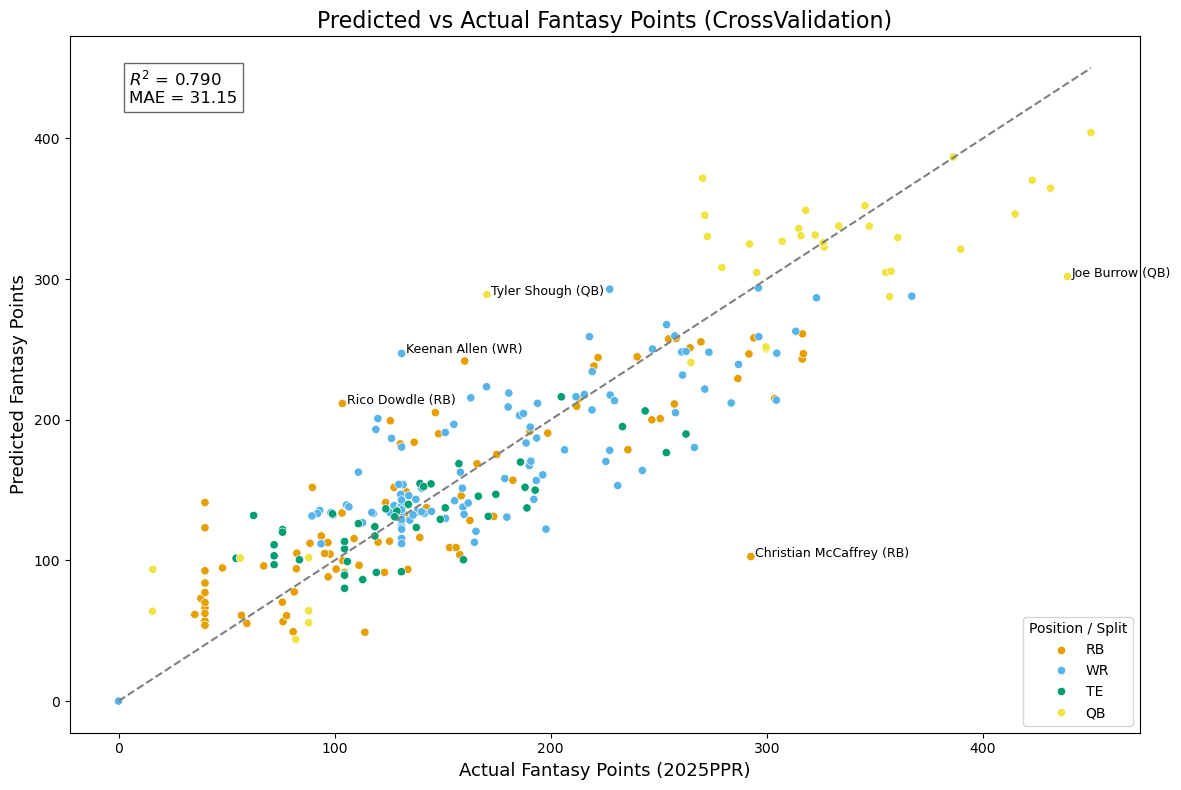

In [31]:

# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (CrossValidation)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

## Function to train and predict for a specific position using RandomizedSearchCV without the 2025 projected data.

In [34]:
'''
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()

    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Define hyperparameter search space
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Initialize the base model
    rf = RandomForestRegressor(random_state=42)

    # Set up RandomizedSearchCV with internal 3-fold CV
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=30,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Fit the randomized search to find best hyperparameters
    rf_random_search.fit(X, y)
    best_rf = rf_random_search.best_estimator_

    # Show best hyperparameters
    print(f"\n{position} - Best Hyperparameters:")
    print(rf_random_search.best_params_)

    # Use cross_val_predict with the best model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(best_rf, X, y, cv=kf, n_jobs=-1)

    # Evaluate CV performance
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"{position} - Cross-Validated MAE: {mae_cv:.2f}")

    # Store out-of-fold predictions
    position_data['Predicted Fantasy Points'] = np.ceil(y_pred_cv)
    position_data['Data Split'] = 'Cross-Validated'

    # Feature importances from final fit on all data
    best_rf.fit(X, y)
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]
# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
qb_features = ['PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']

# Train and predict for each position
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

# Save the projected data to a new CSV file
output_path = "Data/FantasyFootballPrediction_RSCV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)

Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.704  33.10
1       WR  0.600  29.60
2       TE  0.407  29.59
3       QB  0.248  79.08

Negligible performance, so saving computing power and not running the code/script.

'''

'\ndef train_and_predict(position, features):\n    # Filter data for the specific position\n    position_data = combined_stats[combined_stats[\'FantPos\'] == position].copy()\n\n    if position_data.empty:\n        print(f"No data found for position: {position}")\n        return pd.DataFrame()\n\n    X = position_data[features].fillna(0)\n    y = position_data[\'2025PPR\'].fillna(0)\n\n    # Define hyperparameter search space\n    param_distributions = {\n        \'n_estimators\': [100, 200, 300],\n        \'max_depth\': [10, 20, 30],\n        \'min_samples_split\': [2, 5, 10],\n        \'min_samples_leaf\': [1, 2, 4],\n        \'max_features\': [\'sqrt\', \'log2\']\n    }\n\n    # Initialize the base model\n    rf = RandomForestRegressor(random_state=42)\n\n    # Set up RandomizedSearchCV with internal 3-fold CV\n    rf_random_search = RandomizedSearchCV(\n        estimator=rf,\n        param_distributions=param_distributions,\n        n_iter=30,\n        cv=3,\n        scoring=\'neg_

## Combined CV + Full-Training Prediction Function

* Combined version of train_and_predict_cv function that:
* Uses cross_val_predict to evaluate out-of-fold performance (for realistic MAE).
* Fits a final model on the full data to generate actual predicted fantasy points (for production use).
* Returns both the evaluation metrics and full-data predictions.

In [89]:
def train_and_predict_cv_ft(position, features, cv=5):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Initialize model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, max_features='sqrt', random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Step 1: Cross-validated prediction
    y_pred_cv = cross_val_predict(rf, X, y, cv=kf)
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"\n{position} - Cross-Validated MAE (unseen): {mae_cv:.2f}")

    # Step 2: Final model trained on all data
    rf.fit(X, y)
    y_pred_final = rf.predict(X)

    # Feature importances
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Create output DataFrame
    cv_df = position_data.copy()
    cv_df['Predicted Fantasy Points'] = np.round(y_pred_cv, 2)
    cv_df['Data Split'] = 'CrossVal'
    
    ft_df = position_data.copy()
    ft_df['Predicted Fantasy Points'] = np.round(y_pred_final, 2)
    ft_df['Data Split'] = 'FullTrain'

    # Combine CV and FT predictions
    combined_df = pd.concat([cv_df, ft_df], ignore_index=True)
    
    return combined_df[['Player', 'FantPos', 'Data Split', 'Predicted Fantasy Points', '2025PPR']]


# Define feature sets for each position
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD',
               '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL',
               'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD',
               '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL',
               'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL',
               'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD',
               '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD',
               'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

# Train and predict for each position
rb_predictions = train_and_predict_cv_ft('RB', rb_features)
wr_predictions = train_and_predict_cv_ft('WR', wr_features)
te_predictions = train_and_predict_cv_ft('TE', te_features)
qb_predictions = train_and_predict_cv_ft('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions])

# Initialize Note column
all_predictions['Note'] = ''

# Manual overrides (e.g., injury status)
override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Create side-by-side comparison
side_by_side = all_predictions.pivot_table(
    index=['Player', 'FantPos', '2025PPR'],
    columns='Data Split',
    values='Predicted Fantasy Points'
).reset_index()

# Rename columns for clarity
side_by_side.columns = ['Player', 'FantPos', '2025PPR', 'Predicted Fantasy Points (CV)', 'Predicted Fantasy Points (FT)']

# Sort by FantPos (ascending) and 2025PPR (descending)
side_by_side = side_by_side.sort_values(by=['FantPos', '2025PPR'], ascending=[True, False])

# Calculate residuals
side_by_side['Residual_CV'] = (side_by_side['Predicted Fantasy Points (CV)'] - side_by_side['2025PPR']).round(1)
side_by_side['Residual_FT'] = (side_by_side['Predicted Fantasy Points (FT)'] - side_by_side['2025PPR']).round(1)

# Save results
# all_predictions[['Player', 'FantPos', 'Data Split', 'Predicted Fantasy Points', '2025PPR', 'Note']].to_csv(
#    "Data/FantasyFootballPrediction_CVFT.csv", index=False)
side_by_side.to_csv("Data/FantasyFootballPrediction_CVFT_SideBySide.csv", index=False)

# Save final predictions to CSV
# output_path = "Data/FantasyFootballPrediction_CVFT.csv"
# all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE (unseen): 31.75

RB - Feature Importances:
             Feature  Importance
7        2024RushAtt    0.179632
17  2025HealthGrades    0.156511
9         2024RushTD    0.151837
11        2024RecYds    0.089599
10           2024Rec    0.089536
6             2023TD    0.052977
1        2023RushYds    0.049097
0        2023RushAtt    0.048538
8        2024RushYds    0.040811
2         2023RushTD    0.022951
12         2024RecTD    0.022524
3            2023Rec    0.022346
15           2025Age    0.016718
4          2023RecTD    0.014637
16  2024HealthGrades    0.014195
13            2024FL    0.011321
14       HealthGrade    0.010491
5             2023FL    0.006279

WR - Cross-Validated MAE (unseen): 28.50

WR - Feature Importances:
             Feature  Importance
10           2024Rec    0.283444
3            2023Rec    0.125155
12         2024RecTD    0.117097
11        2024RecYds    0.101562
4          2023RecTD    0.051206
6             2023TD    0.047213
15  

* Predicted Fantasy Points (CV): The out-of-fold predictions generated during cross-validation. These simulate how the model would perform on unseen data, giving a more realistic estimate of prediction error.

* Predicted Fantasy Points (Final Model): The predictions made by a model trained on all available data. These are typically more accurate but can be overly optimistic, since the model has seen the full dataset (including each player).

* Predicted Fantasy Points: This is a copy of the Final Model predictions, used as the main output for projections (e.g., fantasy draft prep). It allows for consistent overrides and output formatting.

* 2025PPR: The actual fantasy points scored by the player in 2025. This is used for error analysis and to evaluate model accuracy after the season.

* Use Predicted Fantasy Points (CV) to evaluate the model's real-world accuracy (MAE, scatterplots, etc.), and use Predicted Fantasy Points (Final Model) or Predicted Fantasy Points for forward-looking projections such as rankings and drafting.

* In most real-world ML pipelines: Use cross-validation to evaluate the model's generalization. Then, train the final model on all data to deploy/predict.

In [92]:
# Filter only CV rows
cv_only = all_predictions[all_predictions['Data Split'] == 'CrossVal']

# Evaluate R² and MAE by position using only CV data
position_metrics = []

for pos in cv_only['FantPos'].unique():
    subset = cv_only[cv_only['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

position_metrics_df = pd.DataFrame(position_metrics)

print("\nCV-Only Performance Metrics by Position:")
print(position_metrics_df)


CV-Only Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.731  31.75
1       WR  0.687  26.96
2       TE  0.501  26.76
3       QB  0.616  57.29


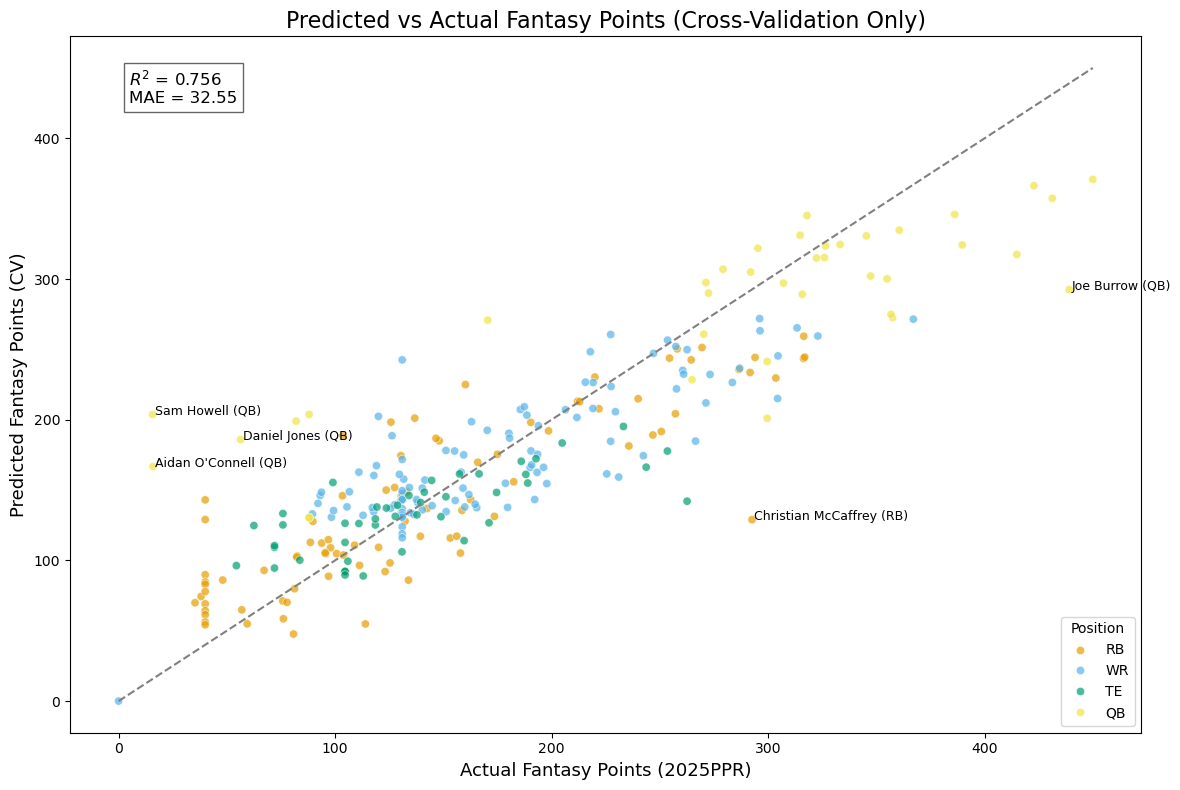

In [94]:
# Filter for CV-only data
cv_only = all_predictions[all_predictions['Data Split'] == 'CrossVal'].copy()

# Calculate CV metrics
r2_cv = r2_score(cv_only['2025PPR'], cv_only['Predicted Fantasy Points'])
mae_cv = mean_absolute_error(cv_only['2025PPR'], cv_only['Predicted Fantasy Points'])

# Calculate residuals
cv_only['Residual_CV'] = np.abs(cv_only['2025PPR'] - cv_only['Predicted Fantasy Points'])

# Get top 5 residual outliers
top_outliers_cv = cv_only.nlargest(5, 'Residual_CV')

# Colorblind-friendly palette for fantasy positions
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cv_only,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette,
    alpha=0.7
)

# Diagonal reference line
min_val = min(cv_only['2025PPR'].min(), cv_only['Predicted Fantasy Points'].min())
max_val = max(cv_only['2025PPR'].max(), cv_only['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 outliers
for _, row in top_outliers_cv.iterrows():
    plt.text(row['2025PPR'] + 1, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (Cross-Validation Only)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points (CV)', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_cv:.3f}\nMAE = {mae_cv:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position', loc='lower right')
plt.tight_layout()
plt.show()

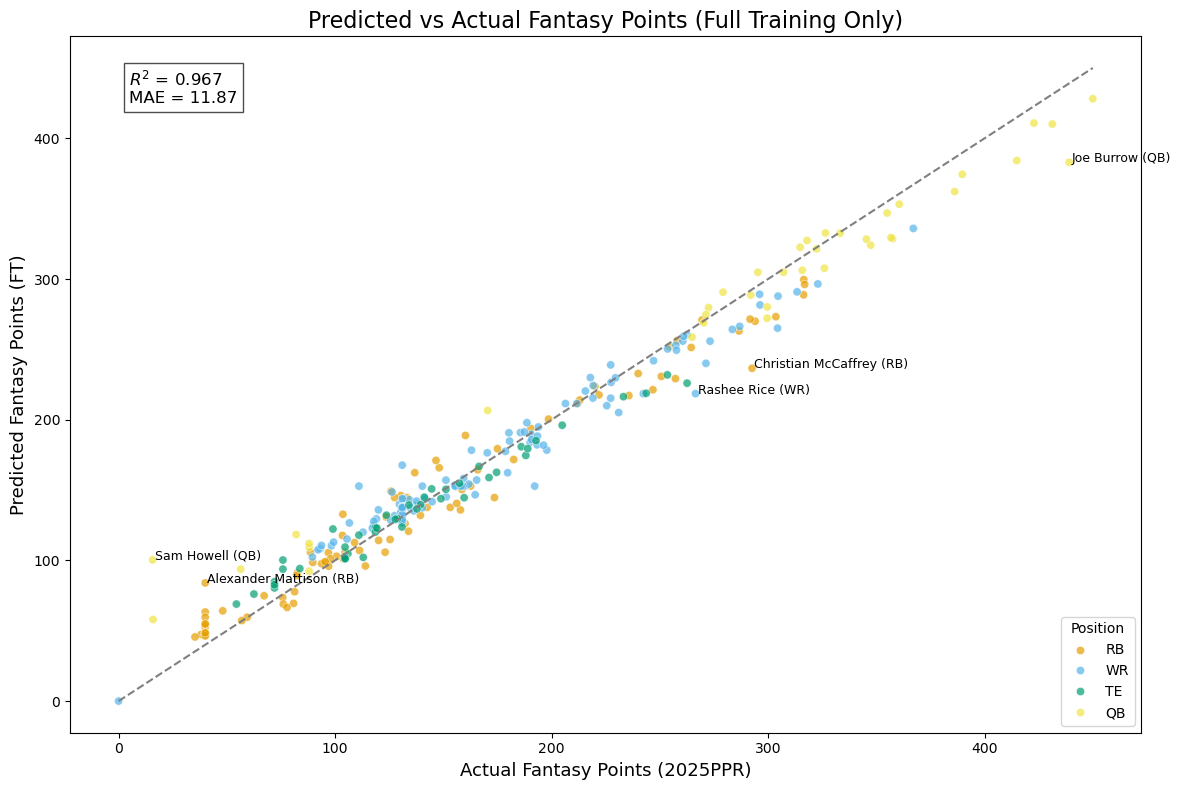

In [81]:
# Filter for Full Training-only data
ft_only = all_predictions[all_predictions['Data Split'] == 'FullTrain'].copy()

# Calculate Full Training metrics
r2_ft = r2_score(ft_only['2025PPR'], ft_only['Predicted Fantasy Points'])
mae_ft = mean_absolute_error(ft_only['2025PPR'], ft_only['Predicted Fantasy Points'])

# Calculate residuals
ft_only['Residual_FT'] = np.abs(ft_only['2025PPR'] - ft_only['Predicted Fantasy Points'])

# Get top 5 residual outliers
top_outliers_ft = ft_only.nlargest(5, 'Residual_FT')

# Colorblind-friendly palette for fantasy positions
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=ft_only,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette,
    alpha=0.7
)

# Diagonal reference line
min_val = min(ft_only['2025PPR'].min(), ft_only['Predicted Fantasy Points'].min())
max_val = max(ft_only['2025PPR'].max(), ft_only['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 outliers
for _, row in top_outliers_ft.iterrows():
    plt.text(row['2025PPR'] + 1, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (Full Training Only)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points (FT)', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_ft:.3f}\nMAE = {mae_ft:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Legend and layout
plt.legend(title='Position', loc='lower right')
plt.tight_layout()
plt.show()

In [83]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['2025PPR']

In [85]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
                Player FantPos Data Split  2025PPR  Predicted Fantasy Points  \
34          Sam Howell      QB   CrossVal     15.7                    203.72   
30     Aidan O'Connell      QB   CrossVal     15.9                    166.71   
26        Daniel Jones      QB   CrossVal     56.4                    185.90   
20        Kirk Cousins      QB   CrossVal     82.0                    198.99   
27          Will Levis      QB   CrossVal     88.0                    203.72   
32        Keenan Allen      WR   CrossVal    131.0                    242.52   
30  Alexander Mattison      RB   CrossVal     40.0                    143.01   
37        Tyler Shough      QB   CrossVal    170.5                    270.75   
52         Gus Edwards      RB   CrossVal     40.0                    129.01   
22         Rico Dowdle      RB   CrossVal    103.6                    188.73   

    ValuationDiff  
34         188.02  
30         150.81  
26         129.50  
20    

In [87]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                 Player FantPos Data Split  2025PPR  Predicted Fantasy Points  \
58  Christian McCaffrey      RB   CrossVal    292.6                    128.91   
2            Joe Burrow      QB   CrossVal    439.1                    292.46   
0          Brock Bowers      TE   CrossVal    262.6                    142.06   
33    Michael Penix Jr.      QB   CrossVal    299.6                    200.95   
4        Jayden Daniels      QB   CrossVal    414.9                    317.41   
0         Ja'Marr Chase      WR   CrossVal    367.1                    271.45   
24           Puka Nacua      WR   CrossVal    304.4                    215.05   
28         Dak Prescott      QB   CrossVal    357.5                    272.59   
29        Justin Fields      QB   CrossVal    356.8                    274.83   
85          Rashee Rice      WR   CrossVal    266.5                    184.78   

    ValuationDiff  
58        -163.69  
2         -146.64  
0         -120